In [1]:
import galarp as grp

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

## Goal: Generate the following figures:

1. $M_{\text{gas}}$ vs $t$
2. $R_{\text{strip}}$ vs $t$
3. $v_z$ vs $z$ as a matrix plot

In [2]:
jz2023_satellite = grp.builtins.JZ2023_Satellite()          # Satellite grav potential
jz2023_cluster_potential = grp.builtins.JZ2023_1e14()       # Host cluster potential
jz2023_cluster_ic = grp.builtins.JZ2023_1e14_IC()           # Satellite galaxy initial conditions

mass_profile = grp.gen_mass_profile(jz2023_satellite)



In [3]:
# Setup initial particle grid

particles = grp.ExponentialGrid(h_R=jz2023_satellite["gas"].parameters["a"],
                           h_z=jz2023_satellite["gas"].parameters["b"],
                           n_particles=10000)

# Only run generate_exponential_positions if temp/positions.npy does not exist

# positions = grp.generate_exponential_positions(h_R=particles.h_R, h_z=particles.h_z,
#                                                n_particles=particles.n_particles,
#                                                Rmax=particles.Rmax, zmax=particles.zmax,
#                                                outname="temp/positions.npy")

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")


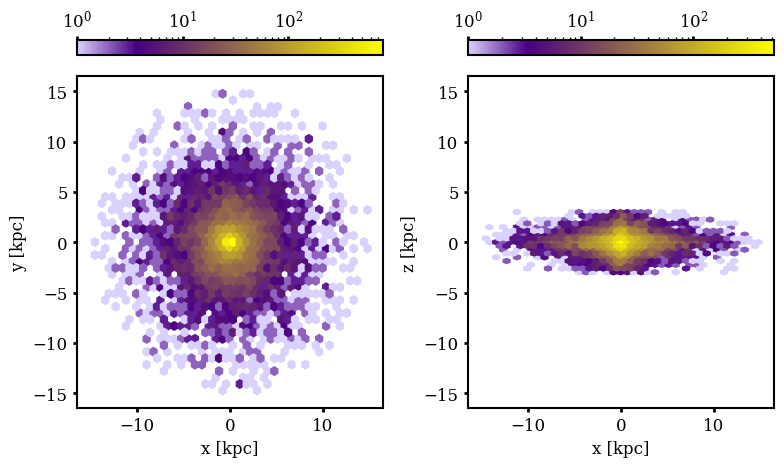

In [4]:

particles.plot_density(cmap=cmap)

In [14]:
inc = 45

wind = grp.InterpolatedWind().from_table("ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                         t_key="col1", vel_keys=["col4", "col5", "col6"],
                                         inc=np.deg2rad(inc))

shadow = grp.UniformShadow(damping=0.4, R_disk = 8 * u.kpc, zmin=0.5 * u.kpc, phi=np.deg2rad(inc), dynamic=True)


## Integrate the RP event with GalaRP

In [6]:
# sim = grp.RPSim(potential=jz2023_satellite, wind=wind, shadow=shadow)
# print(sim)

# orbits = sim.run(particles, )


In [15]:
class InterpolatedWind(grp.RPWind):

    def __init__(self, interp=None, units=galactic, **kwargs):
        super().__init__(**kwargs)
        self.interp = interp
        self.inc = kwargs.get("inc", 0)

        self.unit_vector = [np.cos(self.inc), 0, np.sin(self.inc)]
    
    def evaluate(self, t):
        return self.unit_vector * self.interp(t)

    @staticmethod
    def from_table(fn, t_key, vel_keys, format="ascii",
                   t_units = u.s, v_units = u.cm / u.s, 
                   verbose=False, **kwargs):
        t = Table.read(fn, format=format)

        if verbose:
            print(f'Loaded table with {len(t)} rows and keys: {t.keys()}')

        ts = t[t_key] * t_units.to(u.Myr)

        if not isinstance(vel_keys, list): vel_keys = [vel_keys]

        vels = np.array([t[key] for key in vel_keys])
        v_tot = np.sqrt(np.sum(vels**2, axis=0)) * v_units.to(u.kpc/u.Myr)

        interp = interp1d(ts, v_tot, bounds_error=False, fill_value="extrapolate")

        return InterpolatedWind(interp=interp, **kwargs)


class InterpolatedDensity(grp.Density):
    
        def __init__(self, interp=None, units=u.g/u.cm**3, **kwargs):
            super().__init__(rho=0 * u.g/u.cm**3, **kwargs)
            self.interp = interp
    
        def evaluate(self, t):
            return self.interp(t) * u.g /u.cm **3
    
        @staticmethod
        def from_table(fn, t_key, rho_key,
                       t_units=u.s, rho_units=u.g/u.cm**3,
                       format="ascii", **kwargs):
            t = Table.read(fn, format=format)

            ts = t[t_key] * t_units.to(u.Myr)

            rho = t[rho_key] * rho_units

            interp = interp1d(ts, rho, bounds_error=False, fill_value="extrapolate")
    
            return InterpolatedDensity(interp=interp, **kwargs)



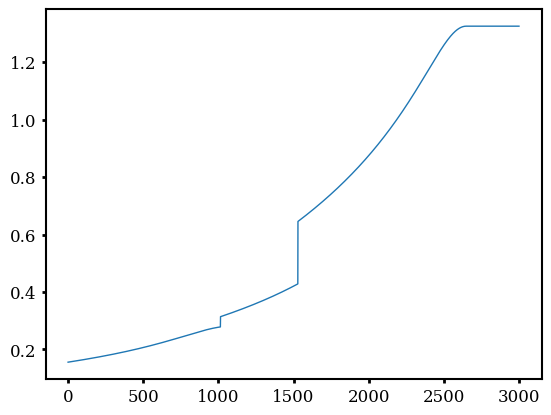

In [16]:
inc = 45

wind = InterpolatedWind().from_table("ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                        t_key="col1", vel_keys=["col4", "col5", "col6"],
                                        inc=np.deg2rad(inc))

rho = InterpolatedDensity().from_table("ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                        t_key="col1", rho_key="col2")

shadow = grp.UniformShadow(damping=0.4, R_disk = 8 * u.kpc, zmin=0.5 * u.kpc, phi=np.deg2rad(inc))



ts = np.arange(0, 3000, 1) * u.Myr

vs = wind.evaluate_arr(ts).T
v_tot = np.sqrt(np.sum(vs**2, axis=0))

rhos = rho.evaluate_arr(ts)

plt.plot(ts, v_tot)

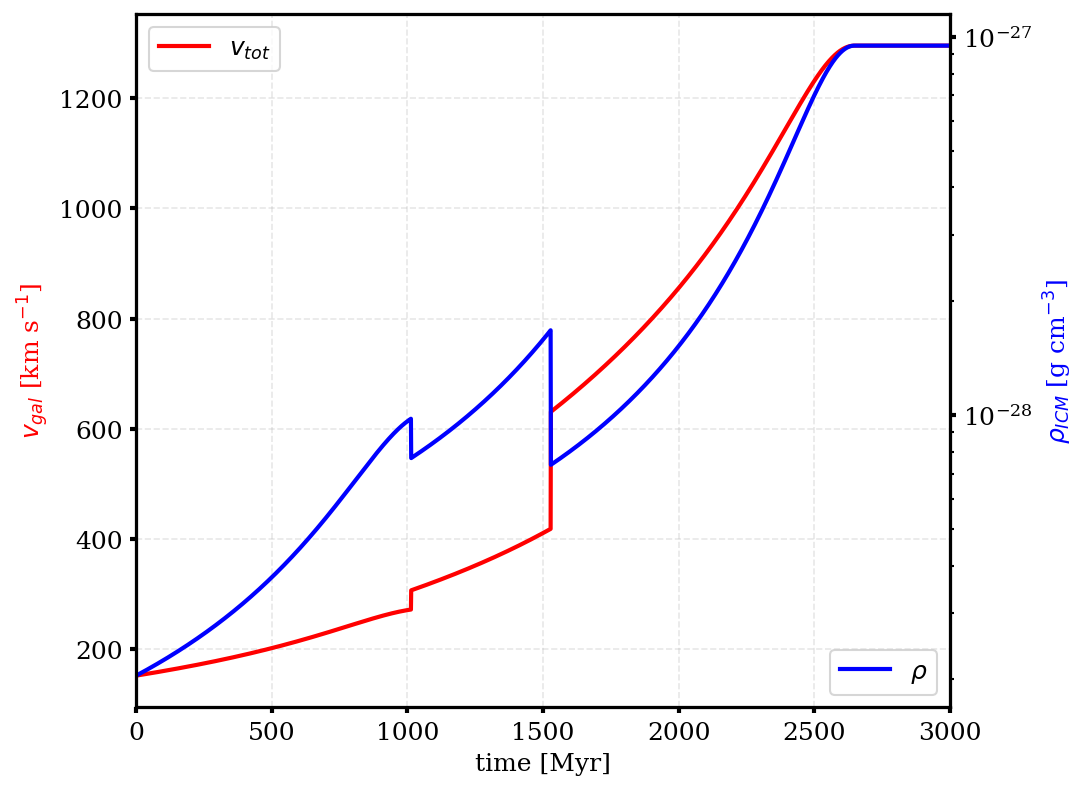

In [17]:
fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=150)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$v_{gal}$ [km s$^{-1}$]',color='r')

plt.plot(ts, v_tot * (u.kpc/u.Myr).to(u.km/u.s), label=r'$v_{tot}$' ,color='r', lw=2)

plt.xlim(0,3000)

plt.legend(loc='upper left')
ax2 = ax.twinx()

ax2.plot(ts, rhos, label=r'$\rho$',color='b', lw=2)

ax2.set_yscale('log')
ax2.set_ylabel(r'$\rho_{ICM}$ [g cm$^{-3}$]',color='b')
ax2.legend(loc='lower right')

#plt.savefig('ICM_profile_stack_1e14_pericenter_wind.png')
plt.show()

In [18]:
sim = grp.RPSim(potential=jz2023_satellite, wind=wind, shadow=shadow)
orbits = sim.run(particles, integration_time=5 * u.Gyr, dt=5 * u.Myr)


--------------------------------------------------------------------------------
-------- Running GALA sim with  0.00e+00 km / s  wind at  0.00  degrees --------
---- Running for 5.0 Gyr  at a timestep of  5.0 Myr  (1.0 Gyr / Myr steps) -----
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 999/999 [00:13<00:00, 72.61it/s]


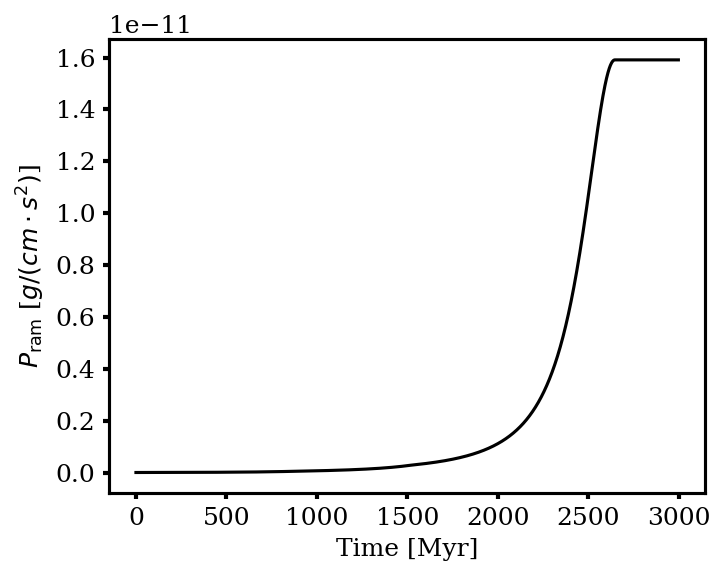

In [19]:
v_tot_with_units = v_tot * u.kpc / u.Myr
rho_with_units = rhos * u.g / u.cm**3

plt.figure(figsize=(5, 4),dpi=150)

plt.plot(ts, (rho_with_units * v_tot_with_units ** 2).to(u.g / u.cm / u.s**2), lw=1.5, color="black")
plt.xlabel("Time [Myr]")
plt.ylabel(r"$P_{\rm ram}$ [$g / (cm \cdot s^{2})$]")
plt.tight_layout()
plt.show()

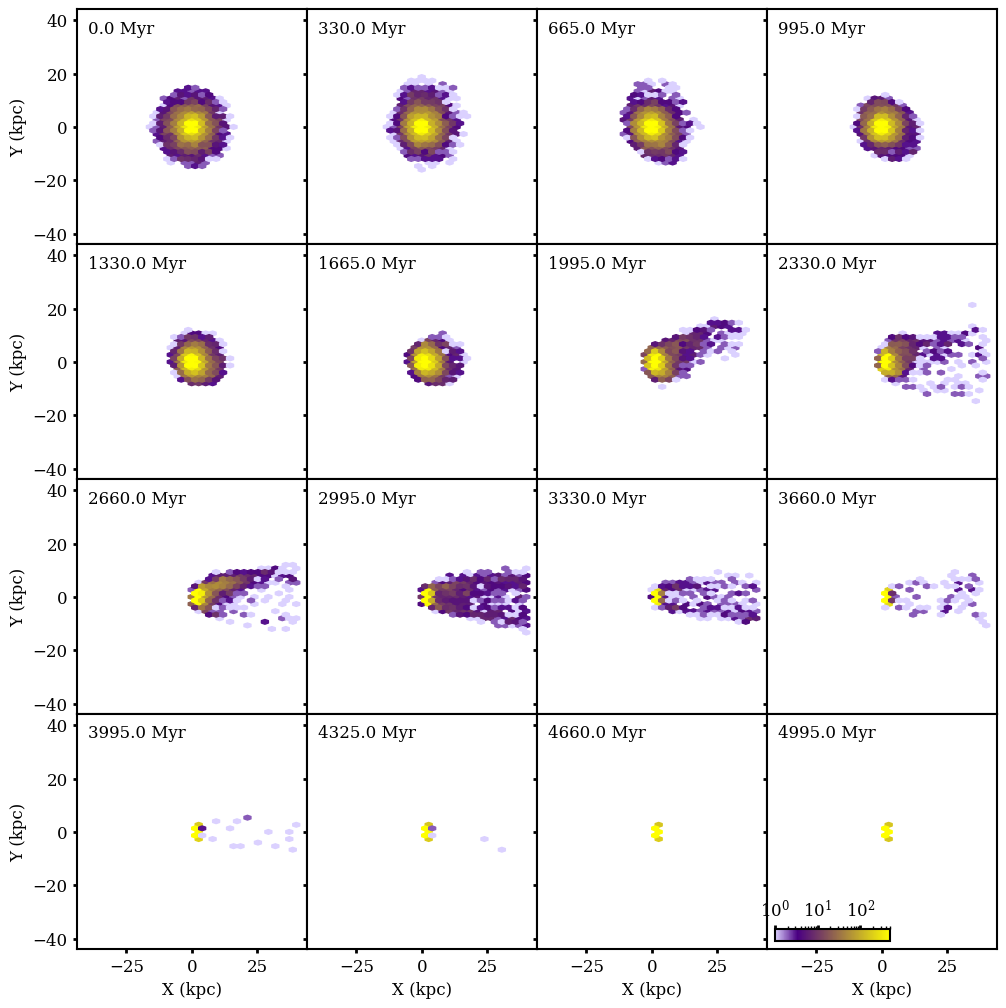

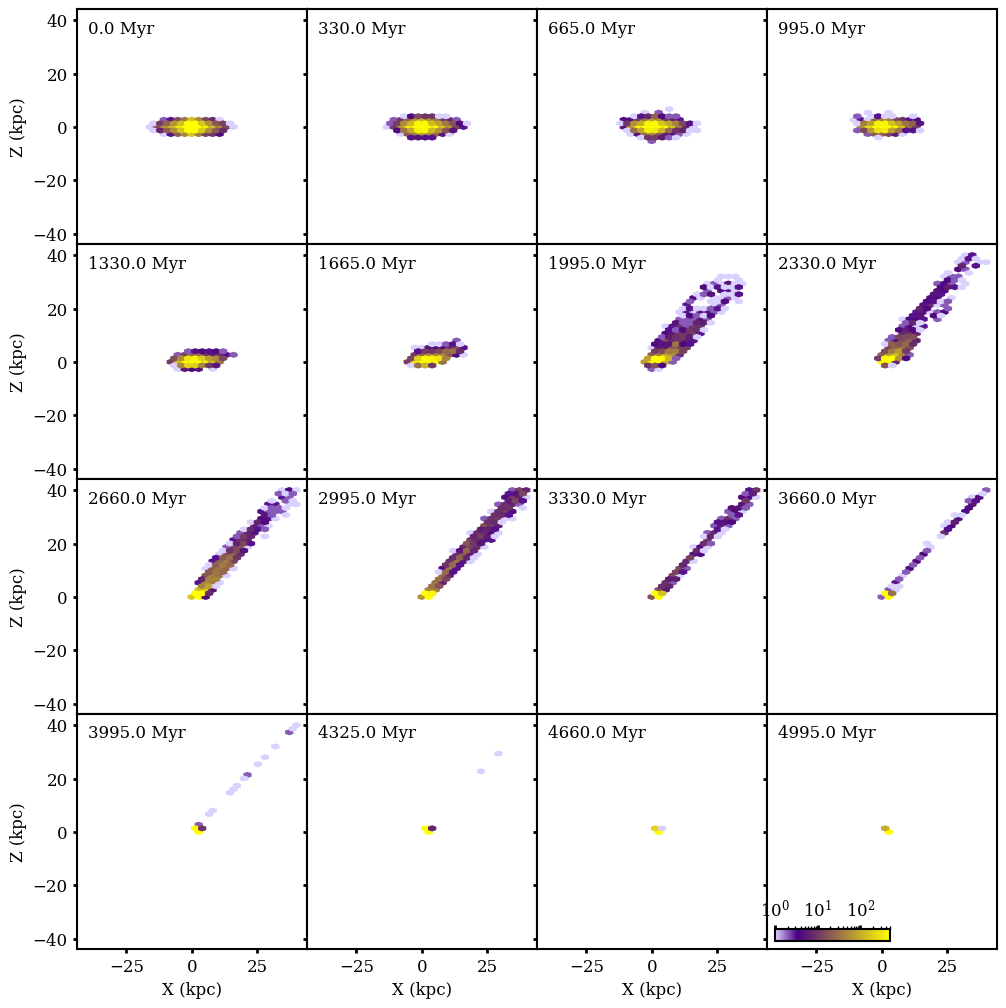

In [20]:
grp.density_matrix(orbits, cmap=cmap, outname="figures/density_matrix_JZ_dup_xy.png")
grp.density_matrix(orbits, cmap=cmap, y_ind=2, ylabel='Z (kpc)', outname="figures/density_matrix_JZ_dup_xz.png")

In [13]:
# grp.k3d_plot([orbits], outname="temp/orbits_JZ_dup.html", duration=120)

orbits.save("temp/orbits_JZ_dup.grp")